<a href="https://colab.research.google.com/github/theSparta/NN_convergence/blob/master/2a_gam_oss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title Imports

from __future__ import division
from __future__ import print_function
import os.path as osp
import json
import re
from IPython.display import display
from copy import copy
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
#@title Enable v2 behaviour
tf.enable_v2_behavior()


In [0]:
#@title Upload the file "medis984c.data"
from google.colab import files
files.upload()

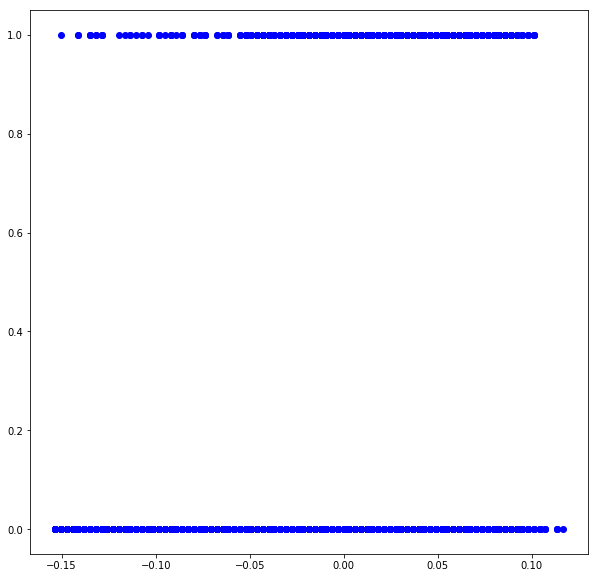

In [0]:
#@title Dataset Processing

# Read dataset
file_name = "medis9847c.data"
df = pd.read_csv(file_name, header = None, sep='\t')
val = df.values

# extract the age feature and normalize it to within the range where most activation threshold lies
x = val[:, 0]
# extract the labels
y = val[:,-1]

# Process and plot dataset  
data_mean = np.mean(x)
data_var = np.mean(np.square(x - data_mean))
data_points = (x - data_mean)/(data_var + 1e-8)
#"""
data_points = data_points[:, np.newaxis]
data_targets = y

NUM_DATAPOINTS = len(data_points)

plt.figure(figsize=(10, 10))
plt.plot(data_points, data_targets, 'bo', label='original data')
plt.show()

In [0]:
#@title Model Helpers

class RBFLayer(tf.keras.layers.Layer):
  
  def __init__(self, num_units, trainable=True, center_init=(-1, 1)):
    super(RBFLayer, self).__init__(trainable=trainable)
    self.num_units = num_units  
    sgn = 2 * np.random.randint(2, size = self.num_units) - 1
    self.sgn = tf.cast(sgn, dtype=tf.float64)
    # Initializing this to lie within the data range
    self._min_val, self._max_val = center_init

  def build(self, input_shape):
    self.beta = self.add_weight(
        name='beta',
        shape=[input_shape[-1], self.num_units],
        initializer=tf.initializers.constant(5.0),
        trainable=True)
    self.c = self.add_weight(
        name='c',
        shape=[1, self.num_units],
        initializer=tf.initializers.random_uniform(
            self._min_val, self._max_val),
        trainable=True)

  # @tf.contrib.eager.defun(input_signature=[
      # tf.contrib.eager.TensorSpec(shape=[None, 1], dtype=tf.float64)])
  def call(self, x):
    center = tf.tile(self.c, [tf.shape(x)[0], 1])
    distances = tf.abs(x - center)
    out = tf.exp(self.beta) * (x - center)
    out = tf.clip_by_value(self.sgn * out, -1, 1)
    # out = tf.tanh(out)
    return out


class SimpleNN(tf.keras.Model):
  """Simple NN model."""

  def __init__(self, num_units, **kwargs):
    super(SimpleNN, self).__init__()
    self.rbf_layer = RBFLayer(num_units, **kwargs)
    self.linear = tf.keras.layers.Dense(
        1, use_bias=True,
        kernel_initializer=tf.initializers.random_uniform(-1, 1))
   
  # @tf.contrib.eager.defun(input_signature=[
      # tf.contrib.eager.TensorSpec(shape=[None, 1], dtype=tf.float64)])
  def call(self, x):
    x = self.rbf_layer(x)
    x = tf.squeeze(self.linear(x), axis=-1)
    return x 


class ComplexNN(tf.keras.Model):
  def __init__(self, num_inputs, num_units, **kwargs):
    super(ComplexNN, self).__init__()
    self.num_inputs = num_inputs
    self.simple_nns = [SimpleNN(num_units, **kwargs)
                       for _ in range(num_inputs)]
    
  # @tf.contrib.eager.defun(input_signature=[
      # tf.contrib.eager.TensorSpec(shape=[None, 1], dtype=tf.float64)])
  def call(self, x):
    list_x = tf.split(x, self.num_inputs, axis=-1)
    out = tf.zeros(x.shape[0], dtype=x.dtype)
    for i, x_i in enumerate(list_x):
      out += self.simple_nns[i](x_i)
    return out

In [0]:
#@title Create tf Dataset
# Assume that each row of `features` corresponds to the same row as `labels`.
assert data_points.shape[0] == data_targets.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((data_points, data_targets))

BATCH_SIZE = 1024 #@param {type: "integer"}
BATCH_SIZE = min(BATCH_SIZE, NUM_DATAPOINTS)
# ds_tensors = dataset.map(lambda x, y : (x/100, y))
ds_tensors = dataset 
ds_tensors = ds_tensors.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=NUM_DATAPOINTS)).batch(BATCH_SIZE)

data_points_tensor = tf.convert_to_tensor(data_points)


In [0]:
#@title Training Helpers

def cross_entropy_loss(model, inputs, targets):
  predicted_y = model(inputs)
  logits = tf.stack([predicted_y, tf.zeros_like(predicted_y)], axis=1)
  labels = tf.stack([targets, 1 - targets], axis=1)
  loss_vals = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=labels, logits=logits)
  return tf.reduce_mean(loss_vals)

def mse_loss(model, inputs, targets):
  predicted = model(inputs)
  return tf.losses.mean_squared_error(predicted, targets)
  

def grad(model, inputs, targets, loss_fn=cross_entropy_loss, train_vars=None):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(model, inputs, targets)
  if train_vars is None:
    train_vars = model.trainable_variables
  return loss_value, tape.gradient(loss_value, train_vars)

In [0]:
#@title Neural Network Model
center_init = (np.min(data_points), np.max(data_points))
nn_model = ComplexNN(num_inputs=1, num_units=150, center_init=center_init)
print(nn_model(data_points_tensor[:BATCH_SIZE]))
nn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor(
[-4.12671718 -0.1686725  -4.12671718 ... -4.38040914 -5.00413472
 -5.50748141], shape=(1024,), dtype=float64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_nn (SimpleNN)         multiple                  451       
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


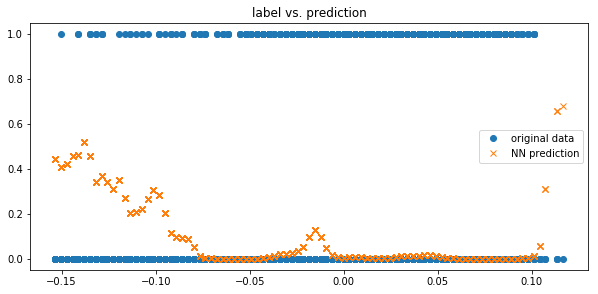

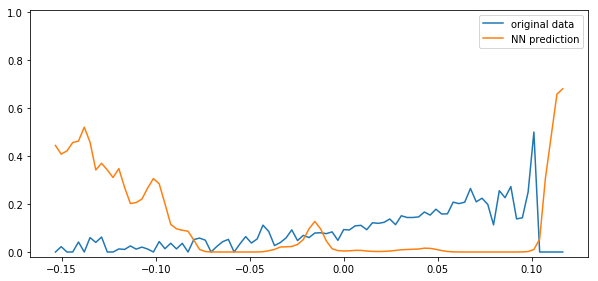

In [0]:
#@title Plot helpers

val = df.values
age = data_points
unique_age = np.unique(age)
get_indices = lambda i:  np.multiply(age[:,0] >= i-0, age[:,0] <= i+0)
h = np.asarray([np.mean(val[get_indices(i), -1]) for i in unique_age]) # the histogram

def plot_hist():
  ## Plot the results
  plt.figure(figsize = (10, 10))

  plt.subplot(2,1,1)
  ## The marginalization plot p(y|x), which is the optimal predictor
  plt.plot(unique_age, h, label = 'original data')

  ## The plot of the neural net's prediction
  pred = (tf.sigmoid(nn_model(unique_age[:, np.newaxis]))).numpy()
  plt.plot(unique_age, pred, label = 'NN prediction')
  plt.legend()
  plt.ylim(-0.02, 1.01)
  plt.show()

def plot_fig():
  plt.figure(figsize = (10, 10))
  plt.subplot(2,1,1)
  plt.title('label vs. prediction')
  plt.plot(data_points, data_targets,'o',label = 'original data')
  pred_logits = nn_model(data_points)
  predicted = tf.sigmoid(pred_logits).numpy()
  plt.plot(data_points, predicted, 'x', label = 'NN prediction')
  plt.legend()
  plt.show()

plot_fig()
plot_hist()


Rank 88
Eigenvalues-> Min: 2.59912726018e-16 Max: 1164.8690073


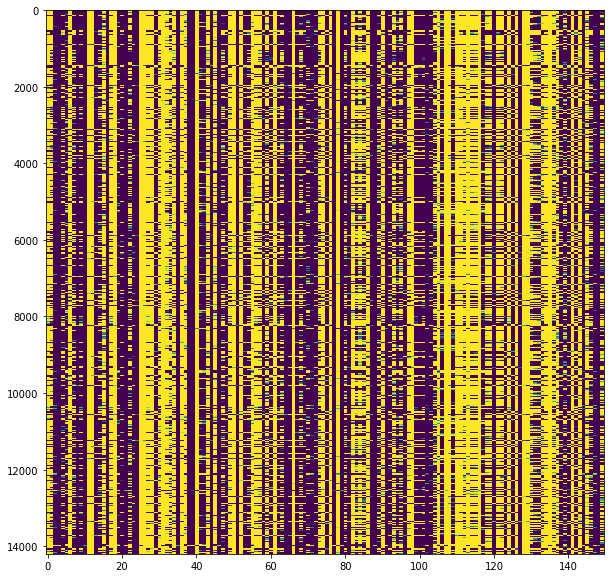

In [0]:
#@title Feature matrix Inspection 
# Code from Simon Kornblith 
X = nn_model.simple_nns[0].rbf_layer(data_points_tensor)
plt.gcf().set_size_inches((10, 10))
plt.imshow(X, aspect='auto', interpolation='nearest')

# Calculate rank and eigenvalues
rank = np.linalg.matrix_rank(X)
print('Rank {}'.format(rank))
assert rank >= len(unique_age), "Rank should be at least number of unique" \
"datapoints to fit data perfectly"

# Eigenvalues of the feature matrix
eigs = np.linalg.svd(X, full_matrices=False, compute_uv=False)
print('Eigenvalues-> Min: {} Max: {}'.format(np.min(eigs), np.max(eigs)))

In [0]:
#@title Learning Rate Decay
learning_rate = 1e-2
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate, 
    global_step, 
    decay_steps=200,
    decay_rate=0.5)
optimizer = tf.train.AdamOptimizer(learning_rate)
model = nn_model


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Iter 324: Loss: 0.339566 Accuracy: 0.891
Iter 649: Loss: 0.324769 Accuracy: 0.891
Plot in Iteration 649


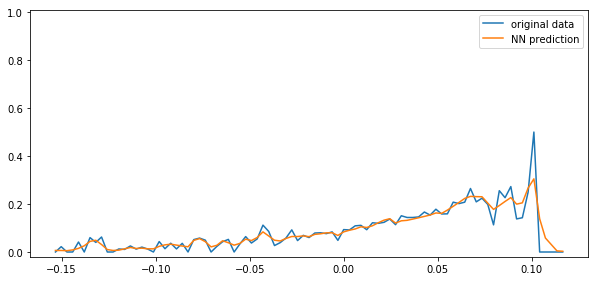

Iter 974: Loss: 0.323667 Accuracy: 0.891
Iter 1299: Loss: 0.322767 Accuracy: 0.891
Plot in Iteration 1299


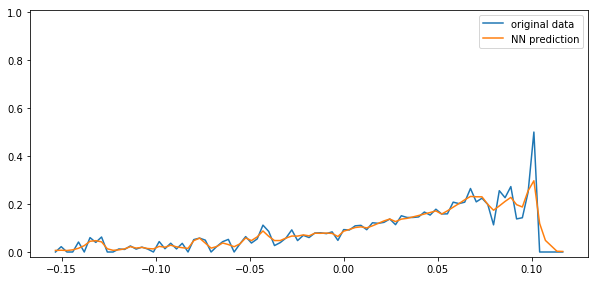

Iter 1624: Loss: 0.322698 Accuracy: 0.891
Iter 1949: Loss: 0.322587 Accuracy: 0.891
Plot in Iteration 1949


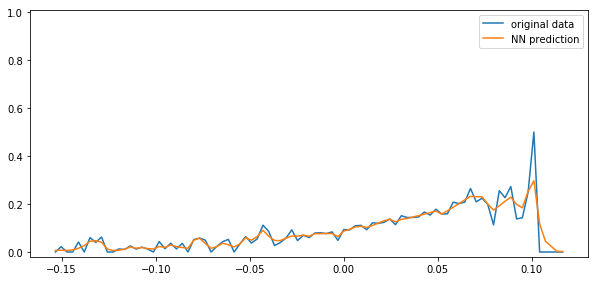

Iter 2274: Loss: 0.322689 Accuracy: 0.891
Iter 2599: Loss: 0.322311 Accuracy: 0.892
Plot in Iteration 2599


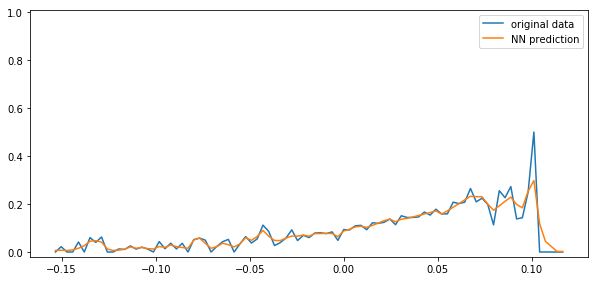

Iter 2924: Loss: 0.322810 Accuracy: 0.891
Iter 3249: Loss: 0.322340 Accuracy: 0.892
Plot in Iteration 3249


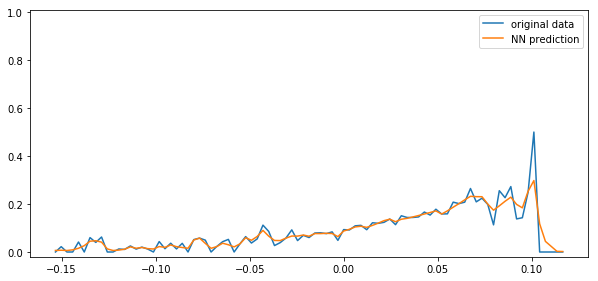

In [0]:
#@title Gradient Descent Training
train_loss_results = []
train_accuracy_results = []

iteration = 0
num_iters_per_epoch = 25 * (NUM_DATAPOINTS // BATCH_SIZE)
num_epochs = 10 #@param
num_iters = num_epochs * num_iters_per_epoch
epoch = 0

tfe = tf.contrib.eager
epoch_loss_avg = tfe.metrics.Mean()
epoch_accuracy = tfe.metrics.Accuracy()
grad_fn = lambda x, y, z=None: grad(
    model, x, y, loss_fn=cross_entropy_loss, train_vars=z)
train_vars = model.trainable_variables

# Training loop - using batches of size `BATCH_SIZE`
for x, y in ds_tensors:   
  # Optimize the model
  loss_value, grads = grad_fn(x, y, train_vars)
  optimizer.apply_gradients(
      zip(grads, train_vars), global_step)

  # Track progress
  epoch_loss_avg(loss_value)  # add current batch loss
  # compare predicted label to actual label
  epoch_accuracy(tf.cast(model(x) > 0, dtype=tf.int32),
                tf.cast(y > 0.5, dtype=tf.int32))
  
  if (iteration + 1) % num_iters_per_epoch == 0:
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Iter {:03d}: Loss: {:.6f} Accuracy: {:.3f}".format(
        iteration, epoch_loss_avg.result(),
        epoch_accuracy.result()))
          
    if (iteration + 1) % (num_iters_per_epoch * 2) == 0:
      print('Plot in Iteration {}'.format(iteration))
      plot_hist()

    # reset epoch counters
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

  iteration += 1
  if iteration > num_iters:
    break

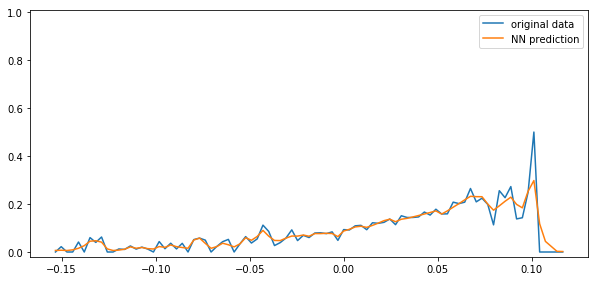

In [0]:
#@title Histogram plot after few gradient descent steps
plot_hist()

## Second Order Optimization

In [0]:
#@title Helpers for using Scipy Optimize 
import scipy.optimize

compute_loss = lambda x: cross_entropy_loss(x, data_points_tensor, data_targets)

def extract_weights(x):
  return [x[:-1, np.newaxis], x[-1, np.newaxis]]  

def merge_weights(W, b):
  return np.concatenate((W.numpy().ravel(), b.numpy()), 0)

def get_nn_vars():
  return nn_model.simple_nns[0].layers[-1].trainable_variables
  
def optfun(x):
  x1 = extract_weights(x)
  nn_model.simple_nns[0].layers[-1].set_weights(x1)  
  return compute_loss(nn_model).numpy()

def jacfun(x):
  x1 = extract_weights(x)
  layer = nn_model.simple_nns[0].layers[-1]
  layer.set_weights(x1)
  with tf.GradientTape() as tape:
    loss = compute_loss(nn_model)
  W_grad, b_grad = tape.gradient(
      loss, layer.trainable_variables)
  return merge_weights(W_grad, b_grad)

In [0]:
#@title Train using a second order optimizer until convergence.
x_init = merge_weights(*get_nn_vars())
res_no_ls = scipy.optimize.minimize(
    optfun, x_init, jac=jacfun, method='L-BFGS-B', 
    tol=1e-8, options={'disp': True})

res_no_ls
print(res_no_ls)

      fun: 0.32176986731180973
 hess_inv: <151x151 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.16141353e-05,  3.74518586e-06, -7.49787310e-06, -1.16141353e-05,
       -5.96587375e-06, -1.11466941e-05, -7.13394840e-06,  7.62649764e-07,
       -9.39971097e-06, -7.04260269e-06, -1.16141353e-05,  1.16141353e-05,
        1.16141353e-05, -9.61026682e-06, -8.35449722e-06, -3.48451325e-06,
       -1.16141352e-05,  7.61597275e-06,  1.16141353e-05, -1.10910570e-05,
       -4.82021229e-06, -1.16141353e-05,  1.63490535e-05, -1.16141353e-05,
       -1.16141353e-05,  1.16141353e-05,  1.16141353e-05,  8.47377685e-06,
        1.22130112e-05, -9.14070104e-06,  8.21150739e-06,  1.16141352e-05,
       -5.48740783e-06,  1.16141353e-05,  1.96192369e-05, -1.16141353e-05,
        8.27246203e-06, -3.62888360e-06, -1.16141353e-05, -1.16141353e-05,
        1.16141352e-05, -1.11253779e-05, -7.80415963e-06,  1.74612219e-05,
       -1.16141353e-05,  1.11697400e-05, -1.16141353e-05, -2.89471576e-06

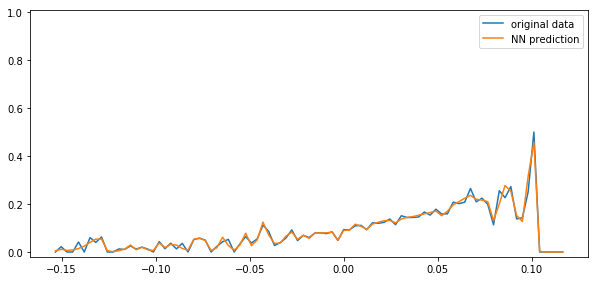

In [0]:
#@title After Second order Optimization
plot_hist()